In [161]:
%matplotlib inline

In [189]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from ipywidgets import interact
import matplotlib.cm as cm
from tqdm import tqdm
from nltk.corpus import reuters
from nltk import bigrams, trigrams
from collections import Counter, defaultdict

if 'cd' not in globals():
    cd = True
    os.chdir('..')


In [23]:
def load(lang, split='train'):
    sents = []
    with open(f'data/{lang}/data/{split}_{lang}/text', 'r') as f:
        for l in f:
            uttid, sent = l.strip().split(' ', maxsplit=1)
            sents.append(sent)
            
    return sents

def load_from_results(path):
    sents = []
    with open(path, 'r') as f:
        for l in f:
            sent = l.rsplit('(', maxsplit=1)[0].strip().replace(' ','').replace('<space>', ' ')
            sents.append(sent)
    return sents

In [24]:
lang = '101'
split = 'train'
sents = load(lang, split)

In [ ]:
bigrams

In [124]:
# def get_bigram_model(sents):
#     # Create a placeholder for model
#     model = defaultdict(lambda: defaultdict(lambda: 0))
#     for sent in tqdm(sents, total=len(sents)):
#         for p1, p2 in bigrams(sent, pad_right=True, pad_left=True):
#             model[p1][p2] += 1
#     return model

In [135]:
def get_model(sents, count='bigram'):
    # Create a placeholder for model
    model = defaultdict(lambda: 0)
    for sent in tqdm(sents, total=len(sents)):
        if count == 'unigram':
            for p in sent:
                model[p] += 1
        elif count == 'bigram':
            for p1, p2 in bigrams(sent, pad_right=True, pad_left=True):
                model[(p1, p2)] += 1
        elif count == 'trigram':
            for p1, p2, p3 in trigrams(sent, pad_right=True, pad_left=True):
                model[(p1, p2, p3)] += 1
        else:
            raise ValueError(f'{count} not implemented')
    return model

In [136]:
def get_freq(model):
    freq = defaultdict(lambda: 0)
    total_count = sum(model.values())
    for k in model.keys():
        freq[k] = model[k] / total_count
    return freq
#     for p1 in model.keys():
#         total_count += sum(model[p1].values()) + len(model[p1])
#     for p1 in model.keys():
#         for p2 in model[p1]:
#             bigram_freq[(p1,p2)] = (model[p1][p2]+1) / (total_count)
#     return bigram_freq

In [150]:
l1, l2 = '101', '402'
l1_split, l2_split = 'train', 'train'
l1_model =  get_model(load(l1, l1_split), count='bigram')
l2_model =  get_model(load(l2, l2_split), count='bigram')
l1_bigram_freq = get_freq(l1_model)
l2_bigram_freq = get_freq(l2_model)

100%|██████████| 41840/41840 [00:00<00:00, 81840.35it/s]


In [183]:
def compute_stats(l1_freq, l2_freq, all_bigrams=None):
    if not all_bigrams:
        freq_keys = list(l1_freq.keys())+list(l2_freq.keys())
    else:
        freq_keys = all_bigrams
    freq_keys_str = [' '.join([str(bi[0]), str(bi[1])]) for bi in freq_keys]
    
    l1_freq = [l1_freq[k] for k in freq_keys]
    l2_freq = [l2_freq[k] for k in freq_keys]
    return freq_keys_str, l1_freq, l2_freq
    # Create names on the x-axis


In [205]:
labels =  ['CR', 'PL', 'SP', 'PO', 'TU', 'GE', 'BG', 'TH', 'CH', 'FR', 'CZ', '203', '101', 'N', '404', '402', '307', '206', '107', '103']
langs = ['Croatian', 'Polish', 'Spanish', 'Portuguese', 'Turkish', 'German', 'Bulgarian', 'Thai', 'Mandarin', 'French', 'Czech', '203', '101', '505', '404', '402', '307', '206', '107', '103']
lang_descs = ['Croatian', 'Polish', 'Spanish', 'Portuguese', 'Turkish', 'German', 'Bulgarian', 'Thai', 'Mandarin', 'French', 'Czech', '203 (Lao)', '101 (Cantonese)', '505 (Dutch)', '404 (Georgian)', '402 (Javanese)', '307  (Amharic)', '206 (Zulu)', '107 (Vietnamese)', '103 (Bengali)']

label2lang = {ll: lang for ll, lang in zip(labels, langs)}
lang2label = {lang: ll for ll, lang in zip(labels, langs)}

In [202]:
all_bigrams = set()
for lang in langs:
    sents = load_eval(lang)
    bigrams(sents, pad_right=True, pad_left=True)
    all_bigrams.update([bi for sent in sents for bi in bigrams(sent, pad_right=True, pad_left=True)])
all_bigrams = sorted(all_bigrams, key=str)

In [253]:
all_trigrams = set()
for lang in langs:
    sents = load_eval(lang)
    trigrams(sents, pad_right=True, pad_left=True)
    all_trigrams.update([tri for sent in sents for tri in trigrams(sent, pad_right=True, pad_left=True)])
all_trigrams = sorted(all_trigrams, key=str)

In [185]:
def load_eval(lang):
    sents = []
    with open(f'data/eval_{lang}/text', 'r') as f:
        for l in f:
            uttid, sent = l.strip().split(' ', maxsplit=1)
            sents.append(sent)
            
    return sents


@interact
def update(l1=langs, l2=langs):
    l1_split, l2_split = 'eval', 'eval'
    l1_model =  get_model(load_eval(l1), count='bigram')
    l2_model =  get_model(load_eval(l2), count='bigram')
    l1_bigram_freq = get_freq(l1_model)
    l2_bigram_freq = get_freq(l2_model)
    ngrams, l1_freq, l2_freq = compute_stats(l1_bigram_freq, l2_bigram_freq, all_bigrams=None)

    plt.figure(figsize=(10,8))
    x = list(range(len(ngrams)))
    plt.bar(x, l1_freq, alpha=0.5, label=f'{l1}')
    plt.bar(x, l2_freq, alpha=0.5, label=f'{l2}')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,8))
    x = list(range(len(ngrams)))
    plt.bar(x, sorted(l1_freq), alpha=0.5, label=f'{l1}')
    plt.bar(x, sorted(l2_freq), alpha=0.5, label=f'{l2}')
    plt.legend()
    plt.show()

interactive(children=(Dropdown(description='l1', options=('Croatian', 'Polish', 'Spanish', 'Portuguese', 'Turk…

In [275]:
bigram_probs = {}
for lang in langs:
    model = get_model(load_eval(lang), count='bigram')
    freq = get_freq(model)
    bigram_probs[lang] = np.array([freq[k] for k in all_bigrams])

100%|██████████| 10265/10265 [00:00<00:00, 62698.73it/s]


In [276]:
bigram_signatures = {}
for lang in langs:
    model = get_model(load_eval(lang), count='bigram')
    freq = get_freq(model)
    bigram_signatures[lang] = np.array(sorted([freq[k] for k in all_bigrams]))

100%|██████████| 10265/10265 [00:00<00:00, 68012.88it/s]


In [269]:
trigram_probs = {}
for lang in langs:
    model = get_model(load_eval(lang), count='trigram')
    freq = get_freq(model)
    trigram_probs[lang] = np.array([freq[k] for k in all_trigrams])

100%|██████████| 10265/10265 [00:00<00:00, 62032.95it/s]


In [257]:
trigram_probs = {}
for lang in langs:
    model = get_model(load_eval(lang), count='trigram')
    freq = get_freq(model)
    trigram_probs[lang] = np.array([freq[k] for k in trigram_probs])

100%|██████████| 10265/10265 [00:00<00:00, 62382.86it/s]


In [271]:
trigram_signatures = {}
for lang in langs:
    model = get_model(load_eval(lang), count='trigram')
    freq = get_freq(model)
    trigram_signatures[lang] = np.array(sorted([freq[k] for k in all_trigrams]))

100%|██████████| 10265/10265 [00:00<00:00, 61718.25it/s]


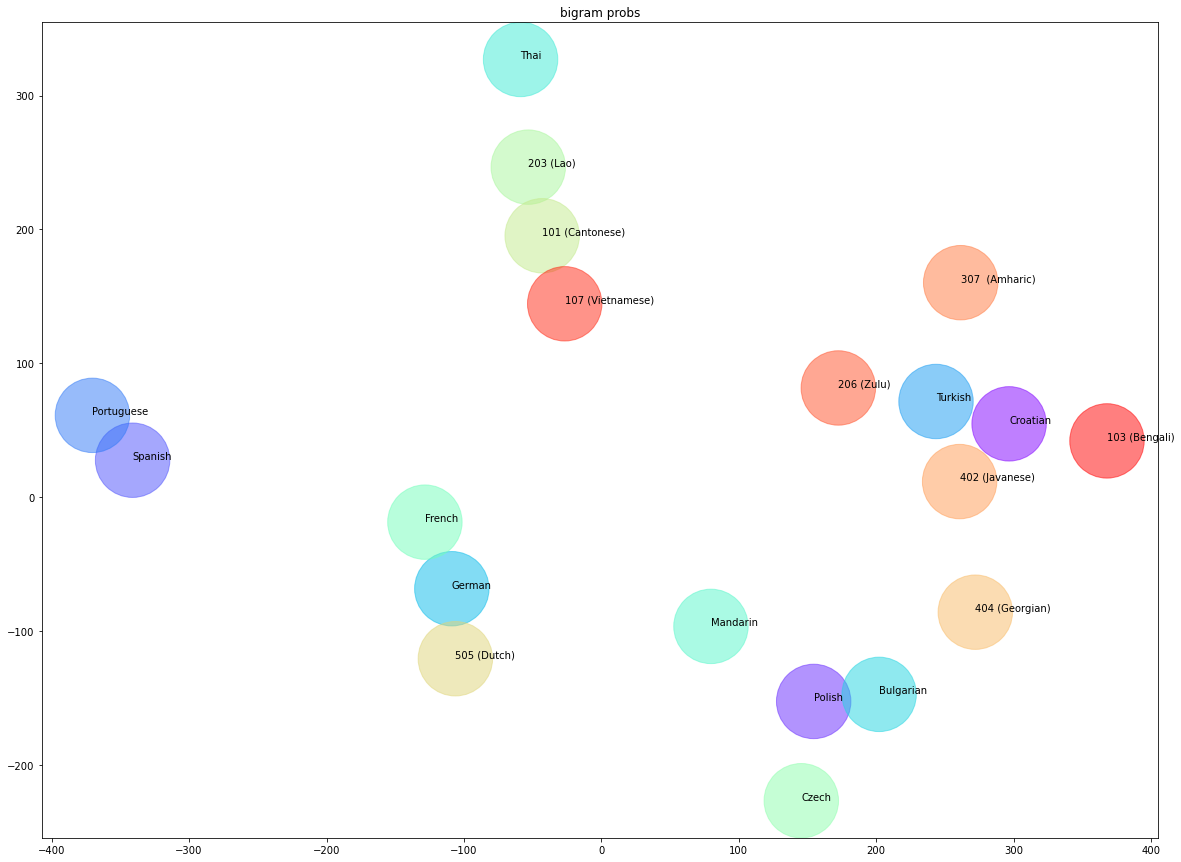

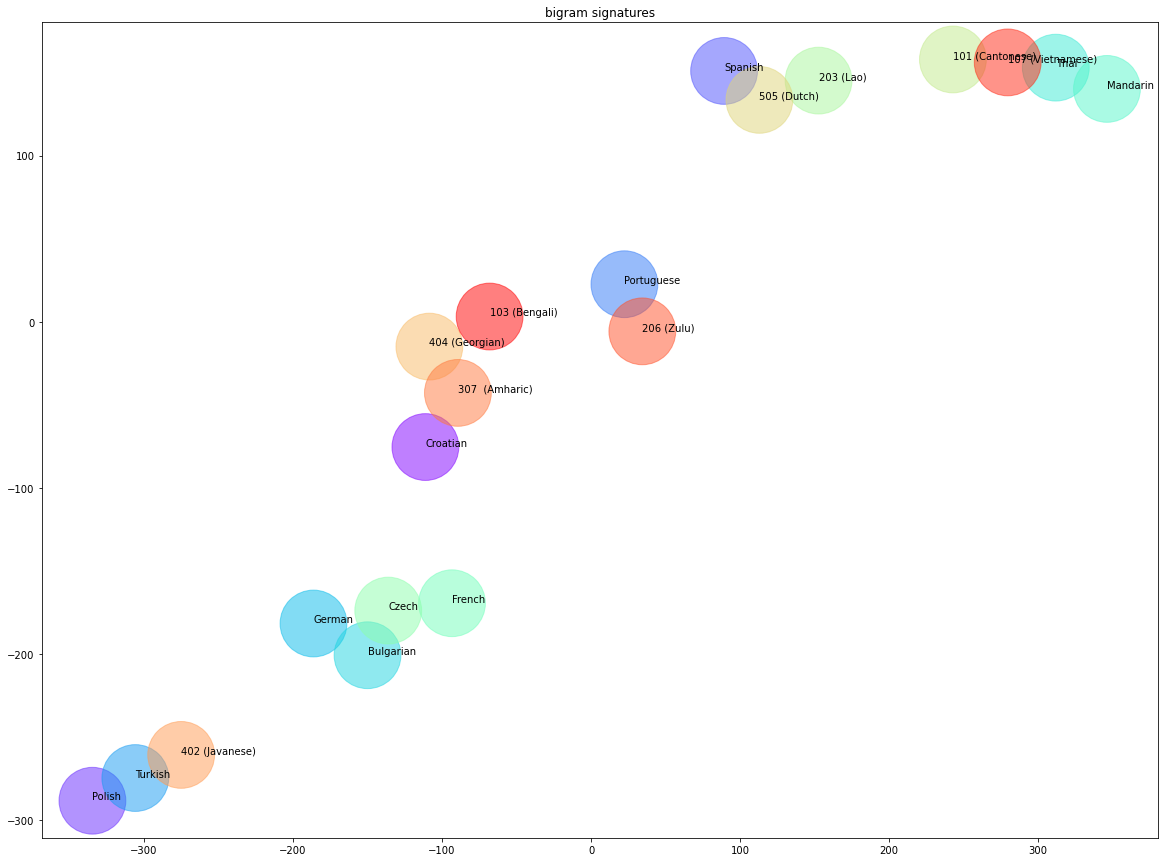

In [278]:
# tsne plot
embs = np.array([bigram_probs[lang] for lang in langs])
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=3)
embs = tsne.fit_transform(embs)
colors = cm.rainbow(np.linspace(0, 1, len(langs)))
x_dist = max(embs[:,0]) - min(embs[:,0])
y_dist = max(embs[:,1]) - min(embs[:,1])
plt.figure(figsize=(20,15))
plt.scatter(embs[:,0], embs[:,1], color=colors, s=10*y_dist, alpha=0.5)

for emb, lang, lang_desc in zip(embs, langs, lang_descs):
    plt.text(emb[0], emb[1]+0.001*x_dist, lang_desc)
plt.title('bigram probs')
plt.savefig('plots/lm/bi_prob')
embs = np.array([bigram_signatures[lang] for lang in langs])
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=3)
embs = tsne.fit_transform(embs)
colors = cm.rainbow(np.linspace(0, 1, len(langs)))
x_dist = max(embs[:,0]) - min(embs[:,0])
y_dist = max(embs[:,1]) - min(embs[:,1])
plt.figure(figsize=(20,15))
plt.scatter(embs[:,0], embs[:,1], color=colors, s=10*y_dist, alpha=0.5)

for emb, lang, lang_desc in zip(embs, langs, lang_descs):
    plt.text(emb[0], emb[1]+0.001*x_dist, lang_desc)
plt.title('bigram signatures')
plt.savefig('plots/lm/bi_sig')

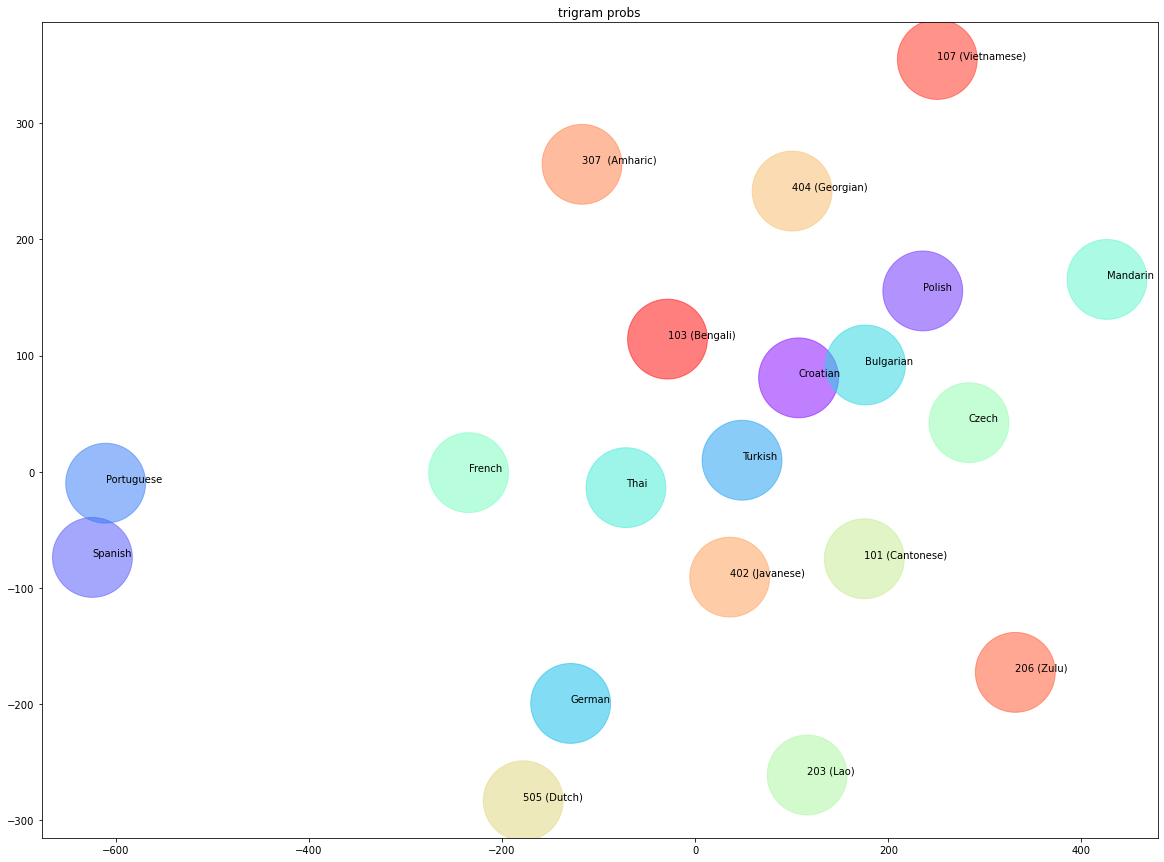

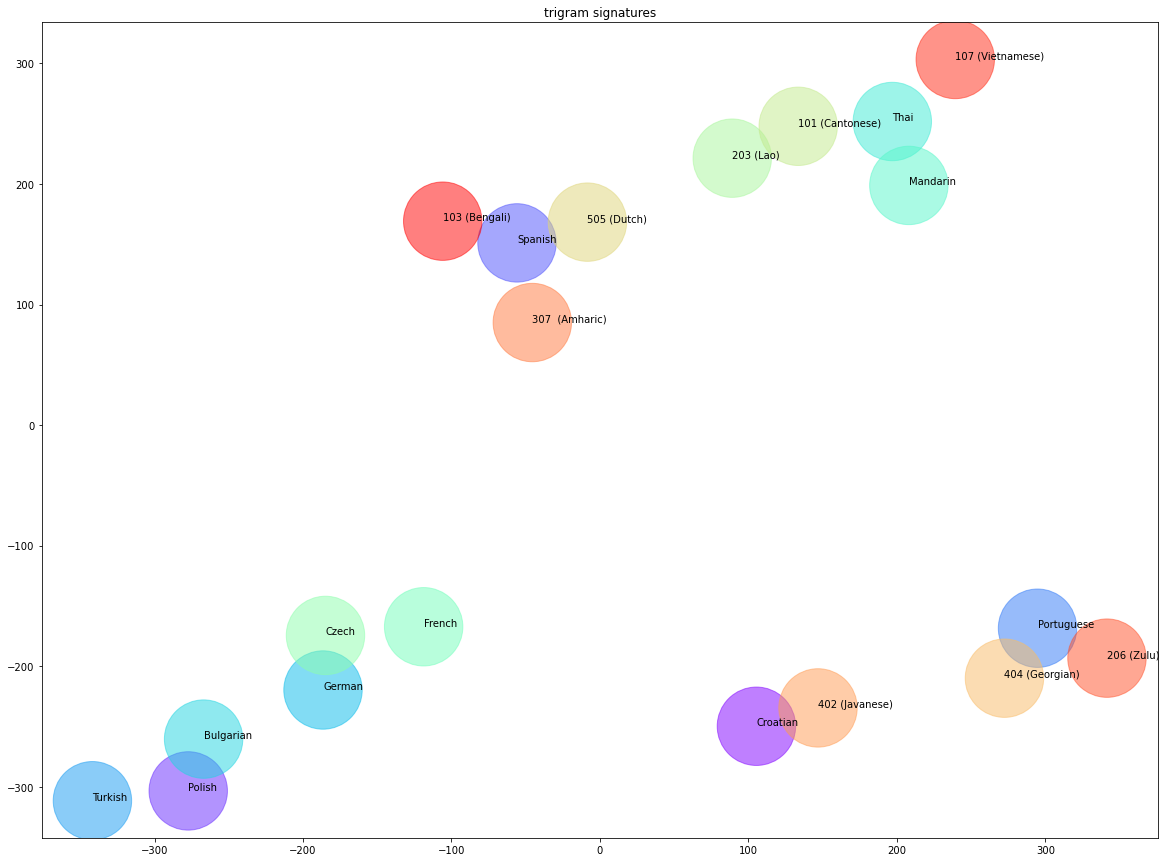

In [279]:
# tsne plot
embs = np.array([trigram_probs[lang] for lang in langs])
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=3)
embs = tsne.fit_transform(embs)
colors = cm.rainbow(np.linspace(0, 1, len(langs)))
x_dist = max(embs[:,0]) - min(embs[:,0])
y_dist = max(embs[:,1]) - min(embs[:,1])
plt.figure(figsize=(20,15))
plt.scatter(embs[:,0], embs[:,1], color=colors, s=10*y_dist, alpha=0.5)

for emb, lang, lang_desc in zip(embs, langs, lang_descs):
    plt.text(emb[0], emb[1]+0.001*x_dist, lang_desc)
plt.title('trigram probs')
plt.savefig('plots/lm/tri_prob')
embs = np.array([trigram_signatures[lang] for lang in langs])
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=3)
embs = tsne.fit_transform(embs)
colors = cm.rainbow(np.linspace(0, 1, len(langs)))
x_dist = max(embs[:,0]) - min(embs[:,0])
y_dist = max(embs[:,1]) - min(embs[:,1])
plt.figure(figsize=(20,15))
plt.scatter(embs[:,0], embs[:,1], color=colors, s=10*y_dist, alpha=0.5)

for emb, lang, lang_desc in zip(embs, langs, lang_descs):
    plt.text(emb[0], emb[1]+0.001*x_dist, lang_desc)
plt.title('trigram signatures')
plt.savefig('plots/lm/tri_sig')

In [273]:
true_lang = 'Croatian'
fake_lang = '101'
ref_path = f'exp/train_pytorch_wav2vecfexlemb/plot_mask_eval_{true_lang}_{lang2label[fake_lang]}_decode/snapshot.ep.30/ref.trn'


In [210]:
sents = load_from_results(ref_path)

In [242]:
true_lang = 'Croatian'
for fake_lang in langs:
    hyp_path = f'exp/train_pytorch_wav2vecfexlemb/plot_mask_eval_{true_lang}_{lang2label[fake_lang]}_decode/snapshot.ep.30/hyp.trn'
    model = get_model(load_from_results(hyp_path), count='bigram')
    freq = get_freq(model)
    bigram_probs[f'{true_lang}_{fake_lang}'] = np.array([freq[k] for k in all_bigrams])
    bigram_signatures[f'{true_lang}_{fake_lang}'] = np.array(sorted([freq[k] for k in all_bigrams]))


100%|██████████| 200/200 [00:00<00:00, 13907.54it/s]


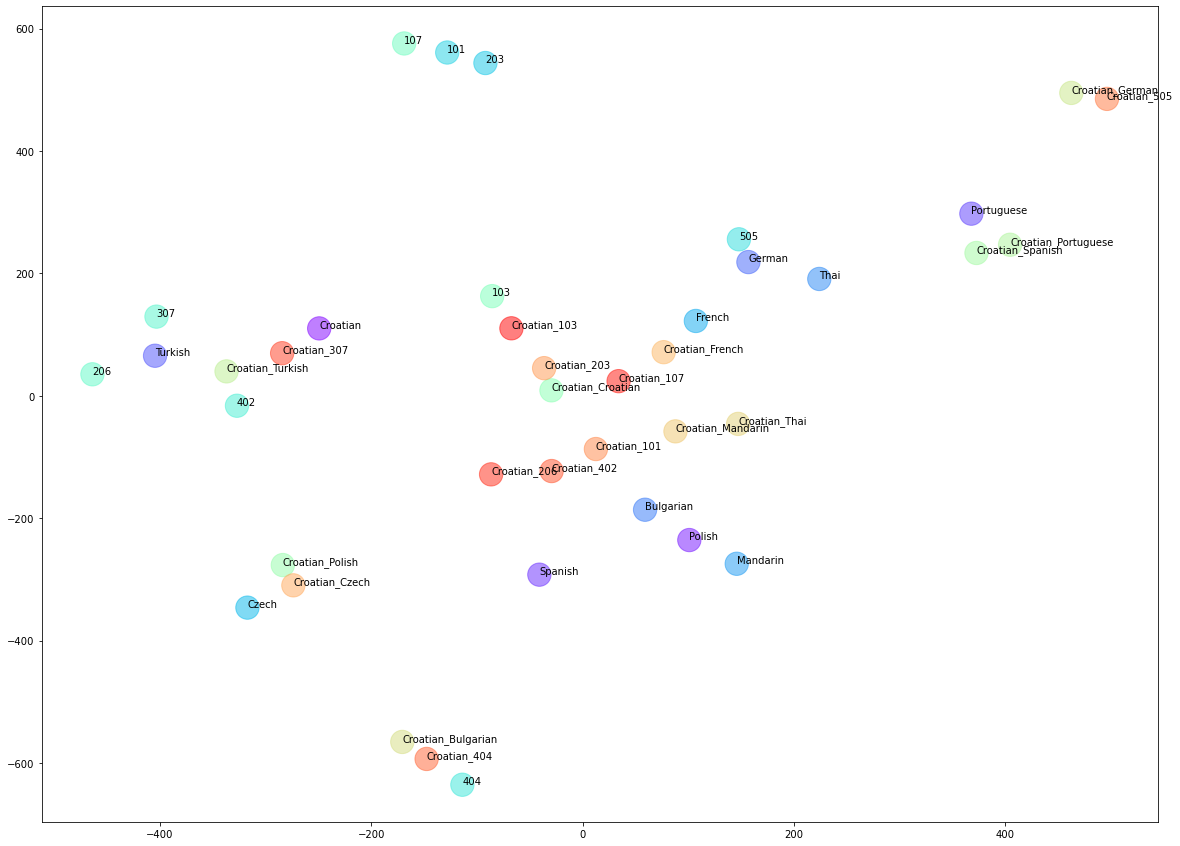

In [251]:
embs = np.array(list(bigram_probs.values()))
colors = cm.rainbow(np.linspace(0, 1, len(embs)))
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=2)
embs = tsne.fit_transform(embs)

x_dist = max(embs[:,0]) - min(embs[:,0])
y_dist = max(embs[:,1]) - min(embs[:,1])
plt.figure(figsize=(20,15))
plt.scatter(embs[:,0], embs[:,1], color=colors, s=0.45*y_dist, alpha=0.5)

for emb, lang_desc in zip(embs, bigram_probs.keys()):
    plt.text(emb[0], emb[1]+0.001*x_dist, lang_desc)

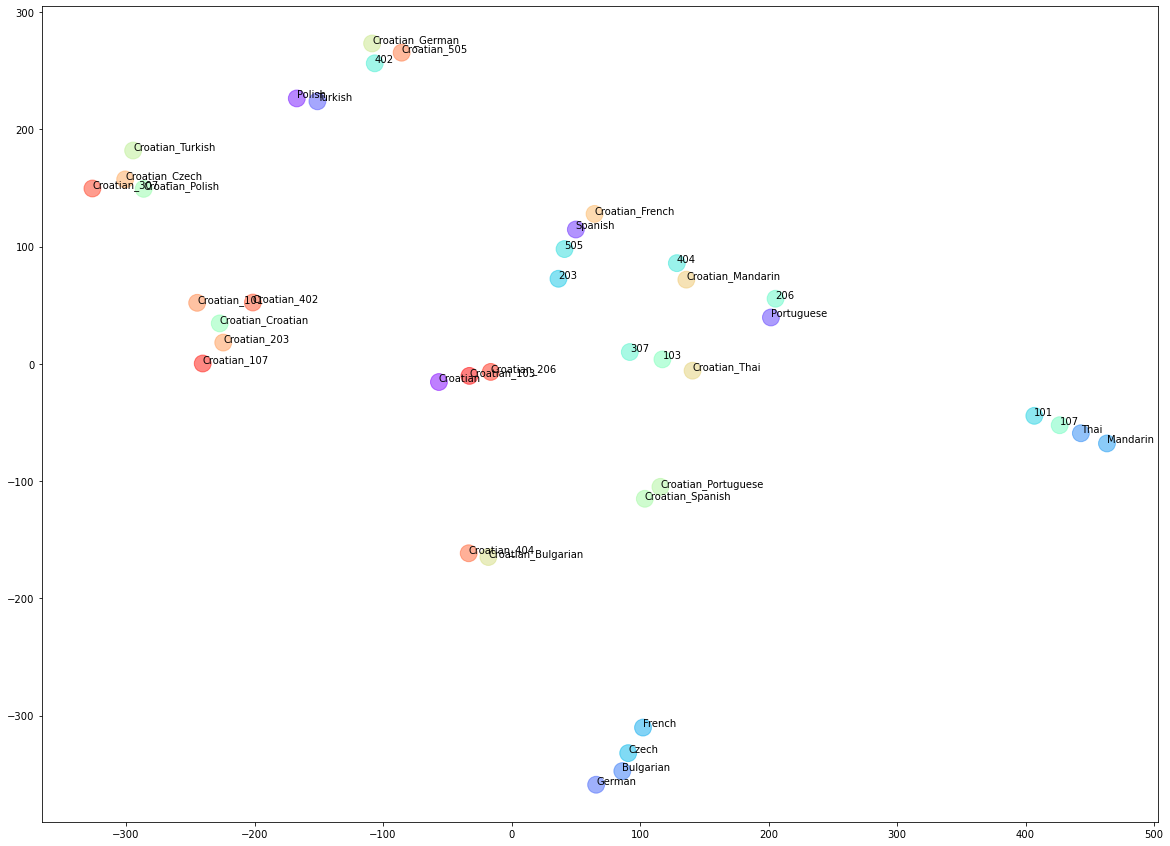

In [252]:
embs = np.array(list(bigram_signatures.values()))
colors = cm.rainbow(np.linspace(0, 1, len(embs)))
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=2)
embs = tsne.fit_transform(embs)

x_dist = max(embs[:,0]) - min(embs[:,0])
y_dist = max(embs[:,1]) - min(embs[:,1])
plt.figure(figsize=(20,15))
plt.scatter(embs[:,0], embs[:,1], color=colors, s=0.45*y_dist, alpha=0.5)

for emb, lang_desc in zip(embs, bigram_probs.keys()):
    plt.text(emb[0], emb[1]+0.001*x_dist, lang_desc)

In [ ]:
def tsne_emb(embs):
    tsne = TSNE(n_components=2, init='pca', random_state=0)
    embs = tsne.fit_transform(embs)
    return embs

In [ ]:
def unigram_stats(l1_bigram_freq, l2_bigram_freq):
    bigram_freq_keys = list(l1_bigram_freq.keys())+list(l2_bigram_freq.keys())
    bigrams_str = [' '.join([str(bi[0]), str(bi[1])]) for bi in bigram_freq_keys]
    x = list(range(len(bigram_freq_keys)))
    l1_freq = [l1_bigram_freq[bigram] for bigram in bigram_freq_keys]
    l2_freq = [l2_bigram_freq[bigram] for bigram in bigram_freq_keys]
    return bigrams_str, l1_freq, l2_freq
    # Create names on the x-axis
#     plt.xticks(x, bigrams_str)


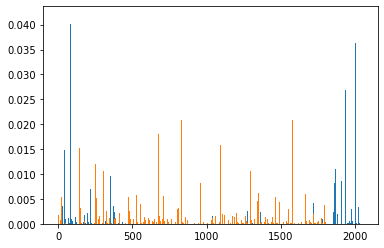

In [133]:
plot_bigram(l1_bigram_freq, l2_bigram_freq)

In [89]:
l1_bigram_freq[None, 'w']

0.0008167191960962047

In [97]:
bigrams = list(l1_bigram_freq.keys())+list(l2_bigram_freq.keys())

bigrams_str = [''.join([str(bi[0]), str(bi[1])]) for bi in bigrams]

x = list(range(len(bigrams)))
l1_freq = [l1_bigram_freq[bigram] for bigram in bigrams]
l2_freq = [l2_bigram_freq[bigram] for bigram in bigrams]
# plt.bar(x, l1_freq)
# plt.bar(x, l2_freq)
# # Create names on the x-axis
# plt.xticks(x, bigrams)

In [101]:
len(x), len(l1_freq)

(5448, 5448)

In [109]:
np.where([type(k) is not float for k in l1_freq])

(array([ 440,  441,  442, ..., 5445, 5446, 5447]),)

In [113]:
l1_bigram_freq[(None,None)]

defaultdict(<function __main__.get_bigram_freq.<locals>.<lambda>.<locals>.<lambda>()>,
            {})

In [110]:
l1_freq[5447]

defaultdict(<function __main__.get_bigram_freq.<locals>.<lambda>.<locals>.<lambda>()>,
            {})

In [111]:
all([type(k) is float for k in l1_freq])

False

In [106]:
type(l1_freq[0])

float

In [ ]:
l1_freq

TypeError: unsupported operand type(s) for +: 'int' and 'collections.defaultdict'

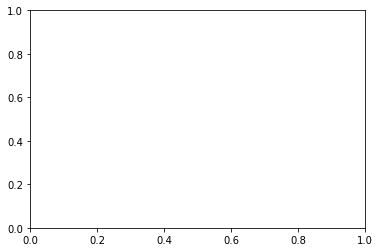

In [102]:
plt.bar(x, l1_freq)

In [129]:
plot_bigram(l1_bigram_freq, l2_bigram_freq)

TypeError: object of type 'function' has no len()

In [46]:
get_bigram_freq(model)

{(None, 'w'): 0.16666666666666666,
 ('w', 'ɐ'): 0.16666666666666666,
 ('ɐ', 'j'): 0.16666666666666666,
 ('j', '˧'): 0.16666666666666666,
 ('˧', '˥'): 0.16666666666666666,
 ('˥', None): 0.16666666666666666}

In [40]:
model['w']

defaultdict(<function __main__.get_bigram.<locals>.<lambda>.<locals>.<lambda>()>,
            {'ɐ': 10487,
             '˧': 41041,
             '˩': 23326,
             'a': 13244,
             'ɔ': 18891,
             '˨': 34028,
             '˥': 16277,
             'u': 2421,
             'i': 114,
             'd': 1,
             'ɛ': 8})

In [38]:
list(model.items())[:3]


[(None,
  defaultdict(<function __main__.get_bigram.<locals>.<lambda>.<locals>.<lambda>()>,
              {'w': 3731,
               't': 2667,
               's': 2251,
               'h': 14771,
               'ɔ': 5877,
               'm': 7889,
               'ŋ': 3968,
               'd': 6853,
               'ɡ': 6750,
               'n': 3578,
               'f': 618,
               'j': 4443,
               'a': 3884,
               'l': 1083,
               'e': 11,
               'b': 1212,
               'u': 19,
               'k': 366,
               'p': 152,
               'ɐ': 19,
               'o': 27,
               'ɛ': 12,
               'i': 3})),
 ('w',
  defaultdict(<function __main__.get_bigram.<locals>.<lambda>.<locals>.<lambda>()>,
              {'ɐ': 10487,
               '˧': 41041,
               '˩': 23326,
               'a': 13244,
               'ɔ': 18891,
               '˨': 34028,
               '˥': 16277,
               'u': 2421,
               '

In [11]:
for sentence in reuters.sents():
    print(sentence)
    break

['ASIAN', 'EXPORTERS', 'FEAR', 'DAMAGE', 'FROM', 'U', '.', 'S', '.-', 'JAPAN', 'RIFT', 'Mounting', 'trade', 'friction', 'between', 'the', 'U', '.', 'S', '.', 'And', 'Japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'Asia', "'", 's', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'far', '-', 'reaching', 'economic', 'damage', ',', 'businessmen', 'and', 'officials', 'said', '.']


In [9]:
model.keys()

dict_keys([(None, None), (None, 'ASIAN'), ('ASIAN', 'EXPORTERS'), ('EXPORTERS', 'FEAR'), ('FEAR', 'DAMAGE'), ('DAMAGE', 'FROM'), ('FROM', 'U'), ('U', '.'), ('.', 'S'), ('S', '.-'), ('.-', 'JAPAN'), ('JAPAN', 'RIFT'), ('RIFT', 'Mounting'), ('Mounting', 'trade'), ('trade', 'friction'), ('friction', 'between'), ('between', 'the'), ('the', 'U'), ('S', '.'), ('.', 'And'), ('And', 'Japan'), ('Japan', 'has'), ('has', 'raised'), ('raised', 'fears'), ('fears', 'among'), ('among', 'many'), ('many', 'of'), ('of', 'Asia'), ('Asia', "'"), ("'", 's'), ('s', 'exporting'), ('exporting', 'nations'), ('nations', 'that'), ('that', 'the'), ('the', 'row'), ('row', 'could'), ('could', 'inflict'), ('inflict', 'far'), ('far', '-'), ('-', 'reaching'), ('reaching', 'economic'), ('economic', 'damage'), ('damage', ','), (',', 'businessmen'), ('businessmen', 'and'), ('and', 'officials'), ('officials', 'said'), ('said', '.'), ('.', None), (None, 'They'), ('They', 'told'), ('told', 'Reuter'), ('Reuter', 'corresponde

In [ ]:
import nltk
nltk.download()
nltk.download('reuters')